# Reprojection

This notebook performs reprojections over raster data arrays on a distributed Dask Cluster. Through all steps of the tutorial, we will see how to:
- Lazily reproject GeoTIFFs in the cloud with `WarpedVRT` from `rasterio`, which is a python wrapper for GDAL.
- Reproject a DataArray to a new CRS with `stackstac` (no GDAL).

Data using in this example is from Sentinel-2 satellite imagery, and we'll also see how to:
- Search for data from item ID using `pystac_client`
- Create a mosaic from data over a time series.

To create true color images for visualization, we use `true_color` function from `xrspatial.multispectral`

Let's get started by importing all necessary libraries.

In [1]:
import planetary_computer as pc
import pystac_client
import pystac 
import satsearch

import xarray as xr
import numpy as np

import stackstac
from stackstac.raster_spec import RasterSpec

import affine
import rioxarray

import rasterio
from rasterio.vrt import WarpedVRT
from rasterio.crs import CRS as RioCRS
from rasterio.enums import Resampling
from pyproj.crs import CRS

import xrspatial.multispectral as ms
import matplotlib.pyplot as plt

## Dask Cluster

Create a Dask Cluster so that our computation can be scaled and done in parallel.

In [2]:
from dask_gateway import GatewayCluster
cluster = GatewayCluster()  # Creates the Dask Scheduler. Might take a minute.

client = cluster.get_client()

cluster.adapt(minimum=4, maximum=24)
print(cluster.dashboard_link)

https://pcc-staging.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/staging.6d0f85023ab4400d8cde173bbe84e9b4/status


## Reproject with WarpedVRT

The region of interest in this section is located in Colorado, USA, centered by Cochetopa Dome and Sawtooth Mountain. We first choose a single scene by its ID as below.

In [33]:
item_id = ['S2B_MSIL2A_20190924T175049_N0212_R141_T13SCC_20201004T164728.SAFE']

catalog = pystac_client.Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')
search = catalog.search(
    collections=['sentinel-2-l2a'],
    ids=item_id
)

item = [pc.sign_assets(i).to_dict() for i in search.items()][0]

item['properties']['proj:epsg']

32613

The selected scene is stored in `EPSG:32613` coordinate system. With [xrspatil.multispectral.true_color](https://xarray-spatial.org/reference/multispectral.html) function, we can create a true color image to see how the actual data looks like.

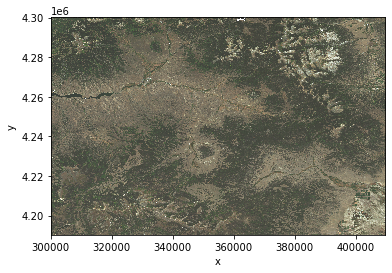

In [34]:
scene_data = stackstac.stack(
    item,
    assets=['B04', 'B03', 'B02'],
    resolution=100,
    chunksize=2048,
)

# visualize selected scene
scence_img = ms.true_color(*scene_data.sel(time=scene_data.time[0]))
scence_img.plot.imshow()

`WarpedVRT` does not require prior download of GeoTIFF files, we can provide the URLs directly. In following script, we fetch imagery from the Microsoft Sentinel-2 Azure Blob Storage and reproject them.

In [5]:
urls = {
    'red': item['assets']['B04']['href'],
    'green': item['assets']['B03']['href'],
    'blue': item['assets']['B02']['href'],
}

urls

{'red': 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/13/S/CC/2019/09/24/S2B_MSIL2A_20190924T175049_N0212_R141_T13SCC_20201004T164728.SAFE/GRANULE/L2A_T13SCC_A013323_20190924T180032/IMG_DATA/R10m/T13SCC_20190924T175049_B04_10m.tif?st=2021-06-14T12%3A08%3A52Z&se=2021-06-16T12%3A08%3A52Z&sp=rl&sv=2020-02-10&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2021-06-15T11%3A08%3A52Z&ske=2021-06-16T12%3A08%3A52Z&sks=b&skv=2020-02-10&sig=xxefhG9k7piDMSeZX2EC79WqkH1ivHBKCxez1U9O7pM%3D',
 'green': 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/13/S/CC/2019/09/24/S2B_MSIL2A_20190924T175049_N0212_R141_T13SCC_20201004T164728.SAFE/GRANULE/L2A_T13SCC_A013323_20190924T180032/IMG_DATA/R10m/T13SCC_20190924T175049_B03_10m.tif?st=2021-06-14T12%3A08%3A52Z&se=2021-06-16T12%3A08%3A52Z&sp=rl&sv=2020-02-10&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2021-06-15T11%3A08%3A52Z&ske=2021-06-16T

#### Web Mercator

In [6]:
web_mecator_crs = RioCRS.from_epsg(3857)

web_mecator_reproj = []

for band, url in urls.items():
    with rasterio.open(url) as src:
        with WarpedVRT(src, src_crs=src.crs, crs=web_mecator_crs) as vrt:
            reproj = rioxarray.open_rasterio(vrt).chunk({'x': 2048,'y': 2048,'band': 1})
            web_mecator_reproj.append(reproj)

web_mecator_reproj = xr.concat(web_mecator_reproj, dim='band')
web_mecator_reproj

<xarray.DataArray (band: 3, y: 11199, x: 11154)>
dask.array<concatenate, shape=(3, 11199, 11154), dtype=uint16, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1 1 1
  * x            (x) float64 -1.195e+07 -1.194e+07 ... -1.18e+07 -1.18e+07
  * y            (y) float64 4.699e+06 4.699e+06 ... 4.557e+06 4.557e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

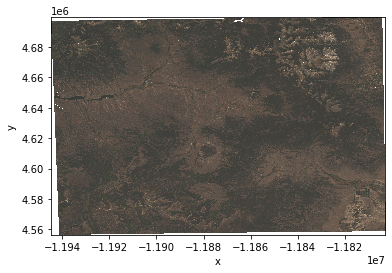

In [7]:
web_mecator_img = ms.true_color(*web_mecator_reproj)
web_mecator_img.plot.imshow()

#### Robinson

In [8]:
robinson_crs = CRS.from_string('ESRI:54030')
robinson_crs = RioCRS.from_wkt(robinson_crs.to_wkt())
robinson_crs

CRS.from_wkt('PROJCS["World_Robinson",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Robinson"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","54030"]]')

In [9]:
height = width = 1000
robinson_bounds = (
    -9438051, 4153437, -9285636, 4046189
)

# calculate destination transform
left, bottom, right, top = robinson_bounds
xres = (right - left) / width
yres = (top - bottom) / height
robinson_transform = affine.Affine(xres, 0.0, left, 0.0, -yres, top)

robinson_transform

Affine(152.415, 0.0, -9438051.0,
       0.0, 107.248, 4046189.0)

In [10]:
robinson_vrt_options = {
    'crs': robinson_crs,
    'transform': robinson_transform,
    'height': height,
    'width': width,
}

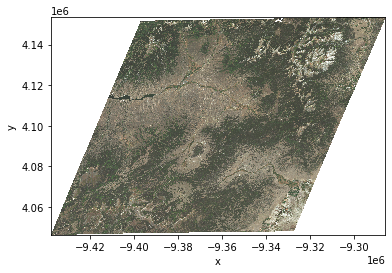

In [11]:
robinson_reproj = []

for _, url in urls.items():
    with rasterio.open(url) as src:
        with WarpedVRT(src, **robinson_vrt_options) as vrt:
            reproj = rioxarray.open_rasterio(vrt).chunk({'x':1000,'y':1000,'band':1})   
            robinson_reproj.append(reproj)
            
robinson_reproj = xr.concat(robinson_reproj, dim='band')

# visualize
robinson_img = ms.true_color(*robinson_reproj)
robinson_img.plot.imshow()

### Reproject with Stackstac

In [12]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

y1, x1 = 38.862012, -107.768858
y2, x2 = 39.635347, -106.879728

search = stac.search(
    bbox=[x1, y1, x2, y2],
    datetime="2020-01-01/2020-12-31",
    collections=["sentinel-2-l2a"],
)

search.matched()

739

In [13]:
%%time
items = [x for x in search.items() if x.properties['eo:cloud_cover'] < 10]

signed_items = pystac_client.ItemCollection([
    pc.sign_assets(item) for item in items
])

len(items)

CPU times: user 2.69 s, sys: 115 ms, total: 2.81 s
Wall time: 33.9 s


261

In [14]:
stack = (
    stackstac.stack(signed_items,
                    epsg=32612,
                    assets=['B04', 'B03', 'B02'],  # red, green, blue
                    chunksize=4096,
                    resolution=100)
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(band = lambda x: x.common_name.rename("band"))  # use common names
)

stack

,Array,Chunk
Bytes,28.67 GiB,37.50 MiB
Shape,"(261, 3, 2124, 2314)","(1, 1, 2124, 2314)"
Count,3916 Tasks,783 Chunks
Type,float64,numpy.ndarray


In [15]:
data = stack.median(dim="time", keep_attrs=True).chunk({'band': 1, 'y': 2400, 'x': 2400}).compute()

data_img = ms.true_color(*data)

#### Equal-area Projection 

In [17]:
equal_area_crs = 6933
equal_area_bounds = stackstac.array_bounds(data, equal_area_crs)
equal_area_bounds

(-10488137.273883387,
 4571341.150428248,
 -10218676.858019227,
 4768386.853056775)

In [18]:
equal_area_spec = RasterSpec(
    epsg=equal_area_crs,
    bounds=equal_area_bounds,
    resolutions_xy=(100, 100)
)

equal_area_spec

RasterSpec(epsg=6933, bounds=(-10488137.273883387, 4571341.150428248, -10218676.858019227, 4768386.853056775), resolutions_xy=(100, 100))

In [19]:
equal_area_reproj = stackstac.reproject_array(data, equal_area_spec)

In [19]:
equal_area_img = ms.true_color(*equal_area_reproj)

#### Space Oblique

In [23]:
space_oblique_crs = 29873
space_oblique_bounds = stackstac.array_bounds(data, space_oblique_crs)

space_oblique_spec = RasterSpec(
    epsg=space_oblique_crs,
    bounds=space_oblique_bounds,
    resolutions_xy=(100, 100)
)

space_oblique_spec

RasterSpec(epsg=29873, bounds=(10439913.5747165, 9683270.718683215, 10739654.793507095, 9992157.502491819), resolutions_xy=(100, 100))

In [38]:
space_oblique_reproj = stackstac.reproject_array(data, space_oblique_spec)

In [39]:
space_oblique_img = ms.true_color(*space_oblique_reproj)

Show results

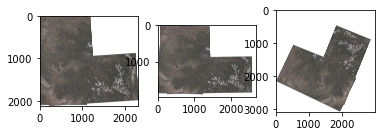

In [40]:
f, ax = plt.subplots(1, 3)
ax[0].imshow(data_img)
ax[1].imshow(equal_area_img)
ax[2].imshow(space_oblique_img)